In [126]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# THE MODEL
![](THE_MODEL.png)

In [58]:
class DefaultParams:
    def __init__(self,**kwargs):
        self.N0 = 1E+7
        self.E0 = 500
        self.SERIOUS_CAPACITY = 2000
        self.R0 = 2.64
        self.NON_INFECTIOUS_INCUBATION_PERIOD = 3
        self.INFECTIOUS_INCUBATION_PERIOD = 3
        self.PRE_ISOLATION_PERIOD = 1
        self.CARRIER_RATE = 0.2
        self.CARRIER_PERIOD = 8
        self.WAIT_PERIOD = 5
        self.HOSP_RATE = 0.075
        self.HOSP_PERIOD = 8
        self.CRITICAL_RATE = 0.025
        self.CRITICAL_PERIOD = 10
        self.LAG_OF_CARE_RATE = 0.0
        
        self.EASY_PERIOD = 7

        self.PRE_ISOLATION_INFECTIOUS_RATE = 1.5
        self.ISOLATED_INFECTIOUS_RATE = 0.1

        self.CRITICAL_FATALITY_RATE = 0.4        

        self.LAG_OF_CARE_FATALITY_RATE = 0.9
        

        self.RECOVERY_PERIOD = 6
        
        self.__dict__.update(kwargs)
        self.EASY_RATE = 1 - self.CARRIER_RATE - self.HOSP_RATE - self.CRITICAL_RATE - self.LAG_OF_CARE_RATE
        self.LAG_OF_CARE_RECOVER_RATE = 1 - self.LAG_OF_CARE_FATALITY_RATE
        self.CRITICAL_RECOVER_RATE = 1 - self.CRITICAL_FATALITY_RATE
        

<IPython.core.display.Javascript object>


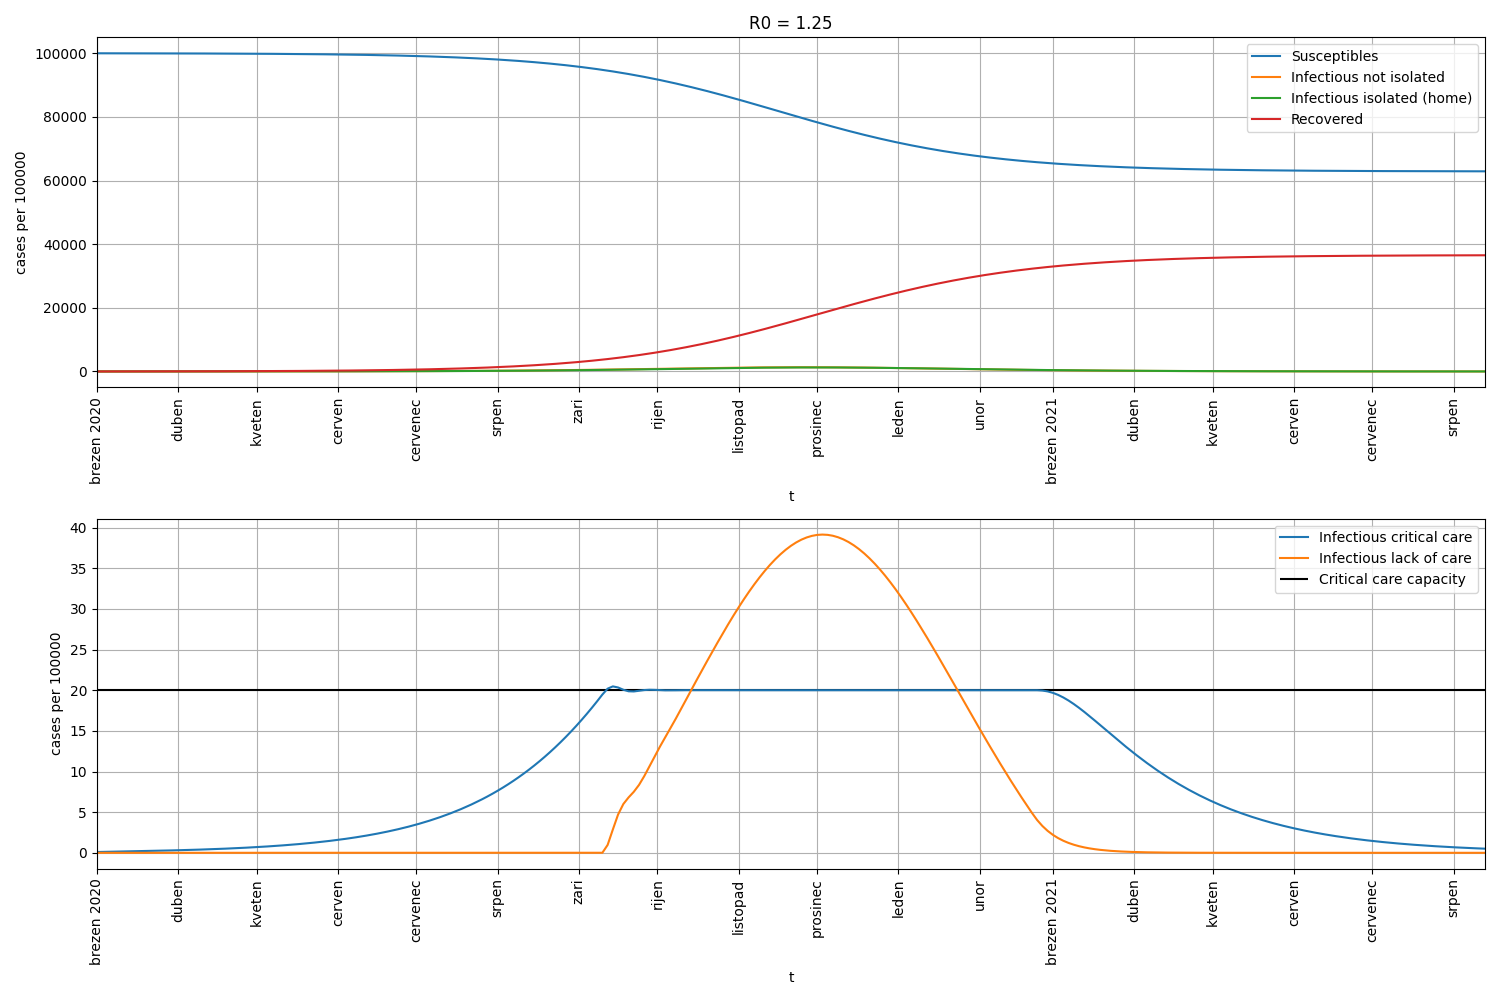

In [129]:

def run(params):    

    def model(y, t):                              
        EFFECTIVE_INFECTIOUS_PERIOD = params.INFECTIOUS_INCUBATION_PERIOD
        EFFECTIVE_INFECTIOUS_PERIOD += params.PRE_ISOLATION_INFECTIOUS_RATE * params.PRE_ISOLATION_PERIOD
        EFFECTIVE_INFECTIOUS_PERIOD += params.CARRIER_RATE * params.CARRIER_PERIOD
        EFFECTIVE_INFECTIOUS_PERIOD += params.EASY_RATE * params.ISOLATED_INFECTIOUS_RATE * params.EASY_PERIOD
        
        infection_rate = params.R0 / EFFECTIVE_INFECTIOUS_PERIOD

        S, E, IA, IS, II, IWH, IWCC, IH, ICC, ILCC, IC, RCC, RLCC, R, D = y
        N = S + E + IA + IS + II + IWH + IWCC + IH + ICC + ILCC + IC + RCC + RLCC + R + D        

        critical_rate = min(params.CRITICAL_RATE, max(0, (1+1/params.CRITICAL_PERIOD)*params.SERIOUS_CAPACITY - ICC) / (max(IS, 1E-14)))
        lag_of_critical_rate = params.CRITICAL_RATE - critical_rate        
        
        weighted_infectious = IA + IS * params.PRE_ISOLATION_INFECTIOUS_RATE + IC + II * params.ISOLATED_INFECTIOUS_RATE

        dSdt = - infection_rate * weighted_infectious * S / N
        dEdt = infection_rate * weighted_infectious * S / N - (1 / params.NON_INFECTIOUS_INCUBATION_PERIOD) * E
        dIAdt = (1 / params.NON_INFECTIOUS_INCUBATION_PERIOD) * E - (1 / params.INFECTIOUS_INCUBATION_PERIOD) * IA    
        dISdt = (1 / params.INFECTIOUS_INCUBATION_PERIOD) * IA - (1 / params.PRE_ISOLATION_PERIOD) * IS

        dIIdt = params.EASY_RATE * (1 / params.PRE_ISOLATION_PERIOD) * IS - (1 / params.EASY_PERIOD) * II

        dIWHdt = params.HOSP_RATE * (1 / params.PRE_ISOLATION_PERIOD) * IS - (1 / params.WAIT_PERIOD) * IWH
        dIHdt = (1 / params.WAIT_PERIOD) * IWH - (1 / params.HOSP_PERIOD) * IH

        dIWCCdt = critical_rate * (1 / params.PRE_ISOLATION_PERIOD) * IS - (1 / params.WAIT_PERIOD) * IWCC
        dICCdt = (1 / params.WAIT_PERIOD) * IWCC - (1 / params.CRITICAL_PERIOD) * ICC
        dRCCdt = params.CRITICAL_RECOVER_RATE * (1 / params.CRITICAL_PERIOD) * ICC - (1 / params.RECOVERY_PERIOD) * RCC

        dILCCdt = lag_of_critical_rate * (1 / params.PRE_ISOLATION_PERIOD) * IS - (1 / params.CRITICAL_PERIOD) * ILCC
        dRLCCdt = params.LAG_OF_CARE_RECOVER_RATE * (1 / params.CRITICAL_PERIOD) * ILCC - (1 / params.RECOVERY_PERIOD) * RLCC        

        dICdt = params.CARRIER_RATE * (1 / params.PRE_ISOLATION_PERIOD) * IS - (1 / params.CARRIER_PERIOD) * IC        

        dDdt = params.CRITICAL_FATALITY_RATE * (1 / params.CRITICAL_PERIOD) * ICC 
        dDdt += params.LAG_OF_CARE_FATALITY_RATE * (1 / params.CRITICAL_PERIOD) * ILCC    

        dRdt = (1 / params.RECOVERY_PERIOD) * RCC
        dRdt += (1 / params.RECOVERY_PERIOD) * RLCC
        dRdt += (1 / params.CARRIER_PERIOD) * IC
        dRdt += (1 / params.HOSP_PERIOD) * IH
        dRdt += (1 / params.EASY_PERIOD) * II

        return [dSdt, dEdt, dIAdt, dISdt, dIIdt, dIWHdt, dIWCCdt, dIHdt, dICCdt, dILCCdt, dICdt, dRCCdt, dRLCCdt, dRdt, dDdt]

    N  = params.N0 # Population
    E = params.E0 # Exposed
    IA = 0 # Infectious assymptomatic
    IS = 0 # Infectious symptomatic (pre isolation)
    II = 0 # Infectious isolated at home
    IWH = 0 # Infectious waiting for hopital (isolated at home)
    IWCC = 0 # Infectious waiting for critical care (isolated at home)
    IH = 0 # Infectious hospitalized
    ICC = 0 # Infectious critical care
    ILCC = 0 # Infectious lag of critical care
    IC = 0 # Infectious carriers
    S = params.N0 - params.E0 # Susceptibles
    RCC = 0 # Recovering critical care
    RLCC = 0 # Recovering lag of critical care
    R = 0 # Recovered
    D = 0 # Deads

    t = np.arange(0, 10*365, 2)

    return t, odeint(model, [S, E, IA, IS, II, IWH, IWCC, IH, ICC, ILCC, IC, RCC, RLCC, R, D], t)


params = DefaultParams(R0=1.25)
t, sol = run(params)


fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))
ax1.set_title(f'R0 = {params.R0}')
ax1.plot(t + 45, 100000*sol[:, 0]/params.N0, label='Susceptibles')
ax1.plot(t + 45, 100000*(sol[:, 3] + sol[:, 2] + sol[:, 10])/params.N0, label='Infectious not isolated')
ax1.plot(t + 45, 100000*(sol[:, 4] + sol[:, 5] + sol[:, 6])/params.N0, label='Infectious isolated (home)')
# ax1.plot(t + 45, 100000*(sol[:, 7] + sol[:, 8]+ + sol[:, 9])/params.N0, label='Infectious hospitalized')
ax2.plot(t + 45, 100000*sol[:, 8]/params.N0, label='Infectious critical care')
ax2.plot(t + 45, 100000*sol[:, 9]/params.N0, label='Infectious lack of care')
ax1.plot(t + 45, 100000*sol[:, 13]/params.N0, label='Recovered')
# ax1.plot(t + 45, 100000*sol[:, 14]/params.N0, label='Dead')

ax2.hlines(xmin=0, xmax=5*365, y=100000*params.SERIOUS_CAPACITY/params.N0, label='Critical care capacity')
for ax in {ax1, ax2}:
    ax.set_xticks(
        np.cumsum([0,31,29,31,30,31,30,31,31,30,31,30,31,31,28,31,30,31,30,31,31,30,31,30,31,31,28,31,30,31,30,31,31,30,31,30,31]),        
    )
    ax.set_xticklabels(['leden','unor','brezen 2020','duben','kveten','cerven','cervenec','srpen','zari','rijen','listopad','prosinec', 
         'leden','unor','brezen 2021','duben','kveten','cerven','cervenec','srpen','zari','rijen','listopad','prosinec',
         'leden','unor','brezen 2022','duben','kveten','cerven','cervenec','srpen','zari','rijen','listopad','prosinec'], rotation=90)
    ax.set_xlabel('t')
    ax.set_xlim(31+29,2.5*t[np.argmax(sol[:, 8])]+31+29)
    ax.set_ylabel('cases per 100000')
    ax.legend(loc='best')


#plt.ylim(0,1.2*100000*np.max(sol[:, 9])/N)

#plt.ylim(0,1.2*100000*np.max(sol[:, 14])/N)

ax1.grid()
ax2.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


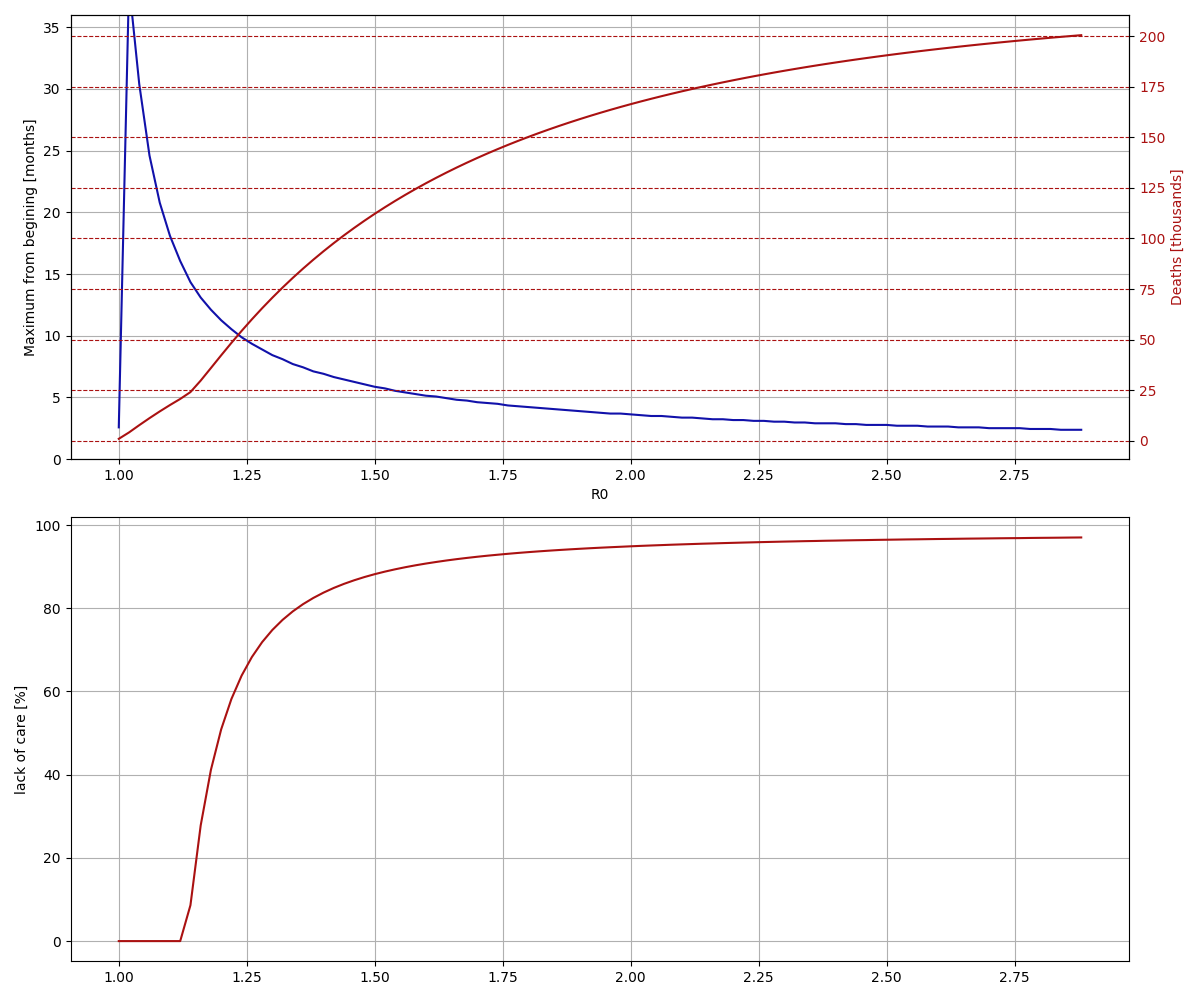

In [110]:
RS = np.arange(1, 2.9, 0.02)
peaks, deaths, lack_of_care = [], [], []
for R0 in RS:
    params = DefaultParams(R0=R0)    
    t, sol = run(params)
    peaks.append(t[np.argmax(sol[:, 8] + sol[:, 9])])
    deaths.append(np.max(sol[:, 14]))
    lack_of_care.append(np.max(sol[:, 9])/np.max(sol[:, 8] + sol[:, 9]))
    

fig, (ax1, ax3) = plt.subplots(2,figsize=(12,10))
ax1.set_xlabel('R0')
ax1.set_ylabel('Maximum from begining [months]')
ax1.set_ylim(0,36)
ax1.grid(True)
ax1.tick_params(axis='y')
ax1.plot(RS, np.array(peaks)/30.4, color='#1111aa')

ax2 = ax1.twinx()
ax2.plot(RS, np.array(deaths)/1000, color='#aa1111')
ax2.set_ylabel('Deaths [thousands]', color='#aa1111')
ax2.tick_params(axis='y', labelcolor='#aa1111')
ax2.grid(True, color='#aa1111', ls='--')


ax3.plot(RS, np.array(lack_of_care)*100, color='#aa1111')
ax3.set_ylabel('lack of care [%]')
ax3.grid()

plt.tight_layout()

<IPython.core.display.Javascript object>


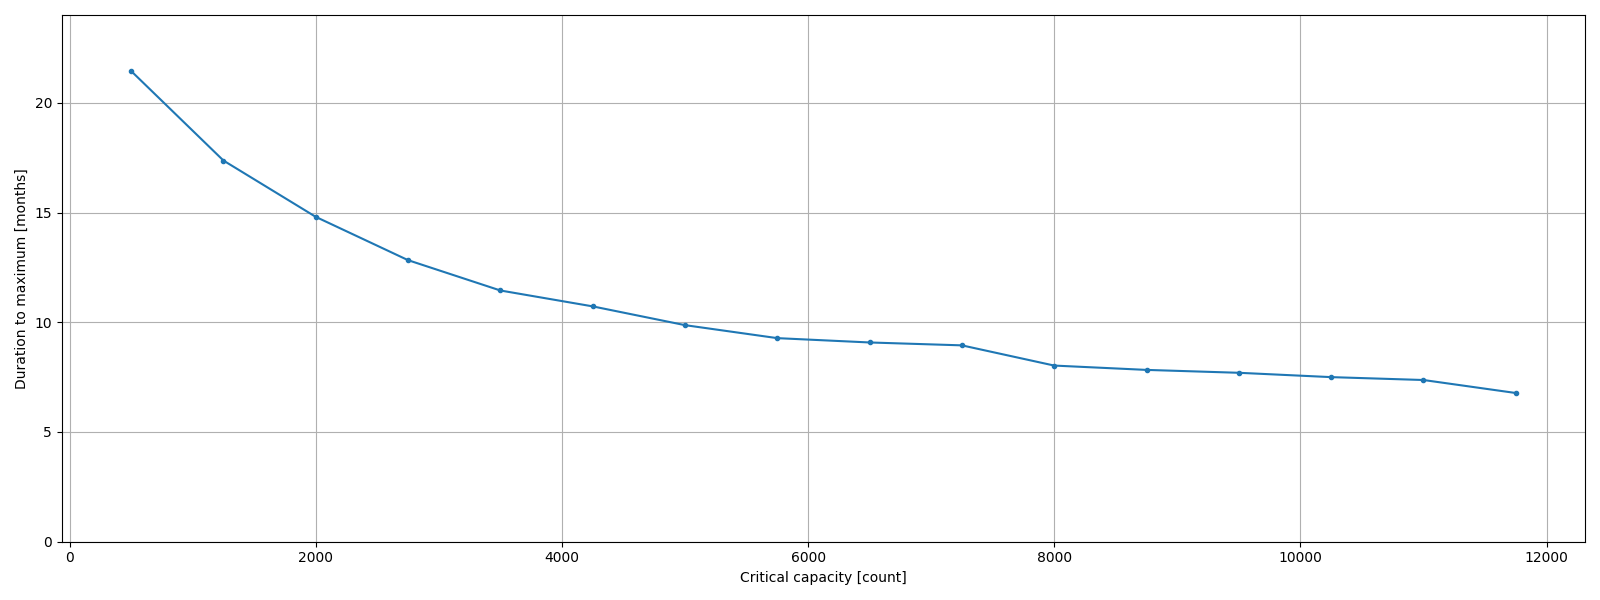

In [114]:
RS = np.arange(1, 2.9, 0.015)

R0s = []
durs = []
capacities = np.arange(500,12000,750)
for capacity in capacities:
    for R0 in RS:
        params = DefaultParams(R0=R0, SERIOUS_CAPACITY=capacity)
        t, sol = run(params)
        if np.max(sol[:, 9]) > 0:
            R0s.append(R0)
            durs.append(t[np.argmax(sol[:, 9])])
            break    
            
plt.figure(figsize=(16,6))
plt.plot(capacities, np.array(durs)/30.4,'.-')
plt.ylim(0,24)
plt.ylabel('Duration to maximum [months]')
plt.xlabel('Critical capacity [count]')
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


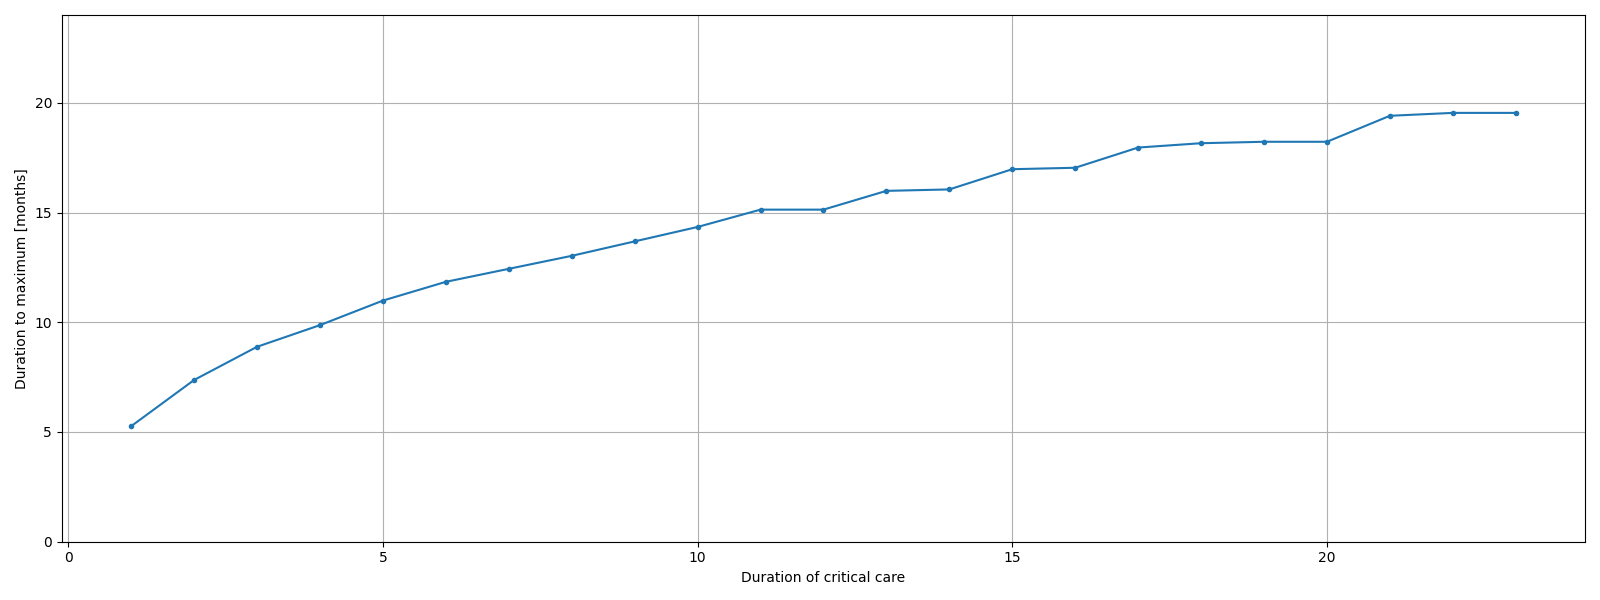

In [116]:
RS = np.arange(1, 2.9, 0.01)

R0s = []
durs = []
periodes = np.arange(1,24,1)
for period in periodes:
    for R0 in RS:
        params = DefaultParams(R0=R0, CRITICAL_PERIOD=period)
        t, sol = run(params)
        if np.max(sol[:, 9]) > 0:
            R0s.append(R0)
            durs.append(t[np.argmax(sol[:, 9])])
            break    
            
plt.figure(figsize=(16,6))
plt.plot(periodes, np.array(durs)/30.4,'.-')
plt.ylim(0,24)
plt.ylabel('Duration to maximum [months]')
plt.xlabel('Duration of critical care')
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


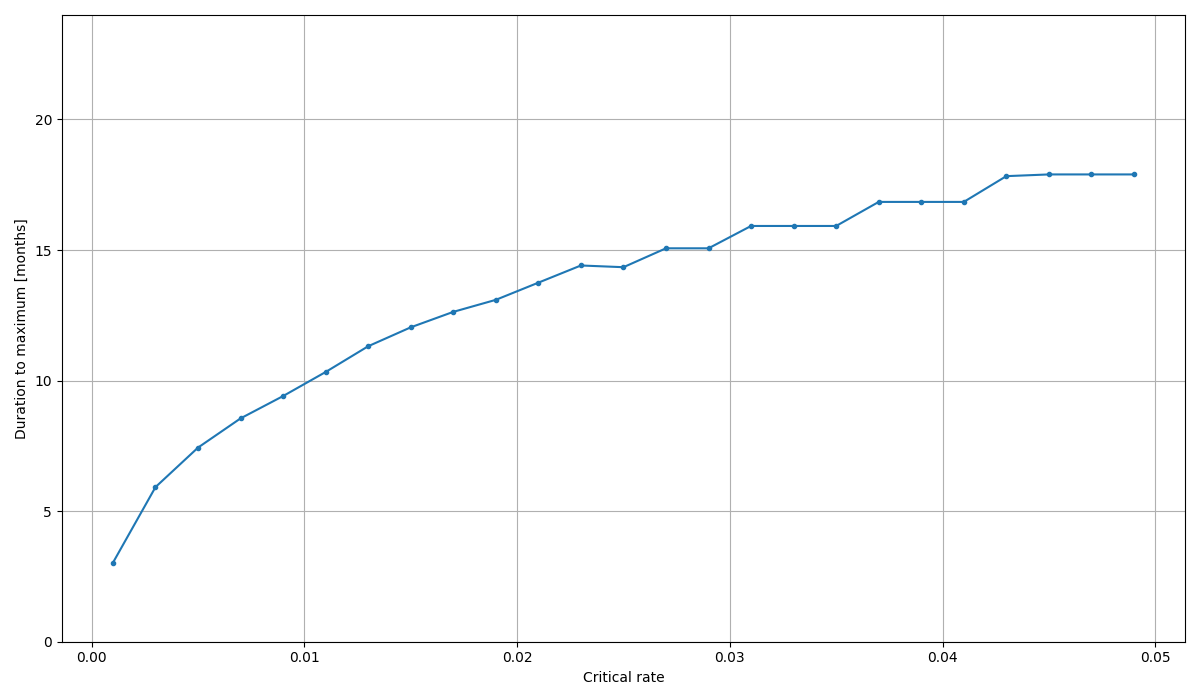

In [120]:
RS = np.arange(1, 2.9, 0.01)

R0s = []
durs = []
rates = np.arange(0.001,0.05,0.002)
for rate in rates:
    for R0 in RS:
        params = DefaultParams(R0=R0, CRITICAL_RATE=rate)
        t, sol = run(params)
        if np.max(sol[:, 9]) > 0:
            R0s.append(R0)
            durs.append(t[np.argmax(sol[:, 9])])
            break    
            
plt.figure(figsize=(12,7))
plt.plot(rates, np.array(durs)/30.4,'.-')
plt.ylim(0,24)
plt.ylabel('Duration to maximum [months]')
plt.xlabel('Critical rate')
plt.grid()
plt.tight_layout()